In [81]:
using Plots, Interpolations, Distributions, Statistics, Optim

# Coursework 2025 - Consumption Saving

## Part I : Approximations

### Interpolation

Consider the function $f(x)=\frac{sin(|x|)}{|x|+0.0001}$ defined on
$[a,b]$ with $a=-2$ and $b=2$.



Consider the grid points $x_i=a+\frac{i}{N-1}(b-a)$ for $i\in[0,N]$.

1.  Define in julia `a`, `b`, `N` and the function `f` . Compute the
    vector of grid points `s` (a vector of size `N`) then the values `y`
    (a vector of size `N`)that `f` takes at these grid points.

In [2]:
a = -2
b = 2
N = 100

function f(x)
  return sin(abs(x))/(abs(x)+0.0001)
end

s = range(a, b, length=N)
y = f.(s)

100-element Vector{Float64}:
 0.4546259821137351
 0.4721981257232264
 0.48972313280299073
 0.5071853162988267
 0.5245689722619838
 0.5418583972472488
 0.5590379057528692
 0.5760918476801626
 0.5930046257904755
 0.6097607131369708
 ⋮
 0.5930046257904755
 0.5760918476801626
 0.5590379057528692
 0.5418583972472488
 0.5245689722619838
 0.5071853162988267
 0.48972313280299073
 0.4721981257232264
 0.4546259821137351

2.  Define a function `interp(s,y,x)` which approximates the original
    function `f` at any $x\in[-2,2]$ but is defined using only `s` and
    `y` (or if you prefer `a`,`b`, `N` and `y`). (hint: you can use the
    library `Interpolations.jl`)

In [3]:
function interp(s,y,x)
  lin_itp = linear_interpolation(s, y , extrapolation_bc=Line())
  return lin_itp(x)
end

interp (generic function with 1 method)


3.  On the same plot, represent `(s,y)` as a scatter plot, the function
    `f` and the interpolated values using `interp`. For the $x$-axis
    choose $[a-0.1, b+0.1]$. How does interp behave outside of $[a,b]$
    (i.e. when it extrtapolates). Can you find a way to make it
    exptrapolate linearly?

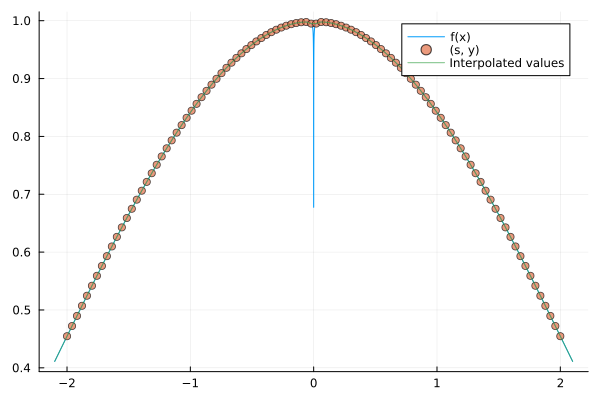

In [4]:
xs = range(a-0.1, b+0.1, length=10000)
interp_y = [interp(s,y,x) for x in xs]

plot(xs, f.(xs), label = "f(x)", lw = 1)
scatter!(s, y, label = "(s, y)",alpha=0.7)
plot!(xs, interp_y, label = "Interpolated values",lw = 1, alpha=0.7)

The points of the linear interpolation are superposed on the f(x) curve when extrapolated close to the interval [a,b], but become further and further apart when extrapolated away from the interval.

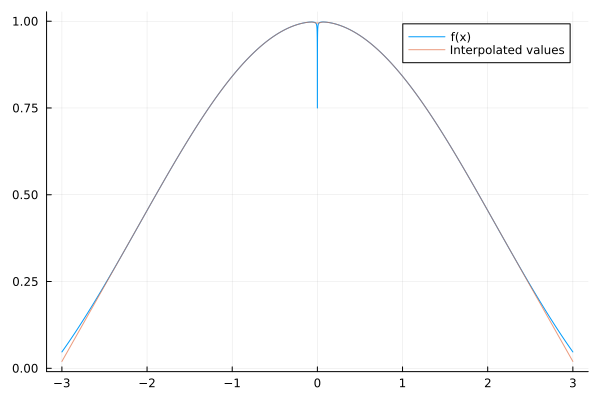

In [5]:
xs = range(a-1, b+1, length=10000)
interp_y = [interp(s,y,x) for x in xs]

plot(xs, f.(xs), label = "f(x)", lw = 1)
plot!(xs, interp_y, label = "Interpolated values",lw = 1, alpha=0.7)

### Discretizing a shock

Consider a random shock $\epsilon$ that follows a normal law with
standard deviation $\sigma$.

The goal here is just to compute numerically the integral

$$\mathbb{E} f(\epsilon)$$

4.  Define a variable $\sigma$. Choose a function `f` so that you can
    compute the above integral in closed form.


In [6]:
σ = 2.0
# Let's take f(x) = x^2
# E[ε^2] = Var(ε) = σ^2

exp_shock_value = σ^2

4.0

#### Monte-Carlo

Take an integer $K>0$.

5.  Try to evaluate the integral above by running $K$ random draws
    i.e. by using the formula
    $f^{MC, K} = \frac{1}{K}\sum_{i=1}^K f(\epsilon_i)$ where
    $\epsilon_i$ is a random draw. Ths is the Monte-Carlo approach.

In [7]:
K = 100_000
f(x) = x^2

# Generate K random draws from a normal distibution N(0, σ^2)
dist = Normal(0, σ)
samples = rand(dist, K)

# Compute the Monte Carlo estimate
f_vals = f.(samples)
mc_estimate = mean(f_vals)

println("For f(ε) = ε^2 : ")
println("E[f(ε)] = $exp_shock_value")
println("Monte-Carlo estimate = $mc_estimate")

For f(ε) = ε^2 : 
E[f(ε)] = 4.0
Monte-Carlo estimate = 4.023100420444059


6.  Evaluate the standard deviation in $f^{MC, K}$ by evaluating this
    function repeatedly. How does the standard deviation depend on $K$ ?

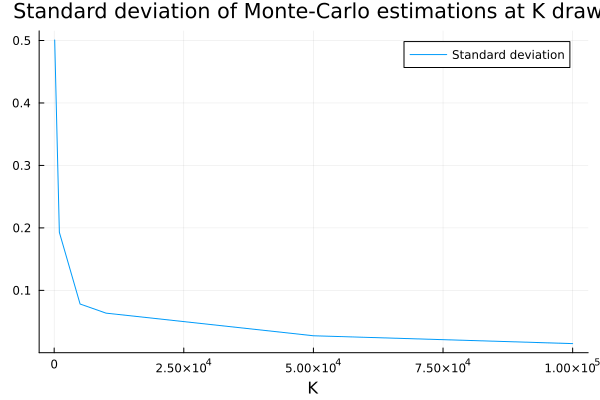

In [8]:
function mc_std(K,N)
  " This function computes the standard deviation of N Monte-Carlo estimations at K random draws."

  dist = Normal(0, σ)
  estimates = zeros(N)

  for i in 1:N
    sample = rand(dist, K)
    estimates[i] = mean(f.(sample))
  end
  return std(estimates)
end

Ks = [100, 1_000, 5_000, 10_000, 50_000, 100_000]
stds = zeros(length(Ks))
for (i, K) in enumerate(Ks)
  stds[i] = mc_std(K,100)
end

plot(Ks, stds, label="Standard deviation", xlabel="K")
title!("Standard deviation of Monte-Carlo estimations at K draws")


#### Gauss-Hermite

Discretizing the shock consists in finding real numbers $(x_1, ... x_K)$
and positive real numbers $(w_1, ... w_K)$ such that for a “suitable”
function $f(\epsilon)$ we can write:

$$\mathbb{E} f(\epsilon) \approx \sum_{i=1}^K w_i f(e_i)$$

The Gauss-Hermite quadrature is such a discretization scheme. It is
widely documented and there are good Julia libraries for it.

7.  Approximate the expectation above using Gauss-Hermite nodes and
    weights. What is the error? How does it depend on $K$ for the
    function you have chosen?

In [9]:
using FastGaussQuadrature

In [28]:
function gh_expectation(f, σ, K)
  x, w = gausshermite(K, normalize=true)
  return sum(w .* f.(σ .* x))
end

Ks = 1:2:20
errors = zeros(length(Ks))
for (i, k) in enumerate(Ks)
    errors[i] = abs(exp_shock_value - gh_expectation(f, σ, k))
end

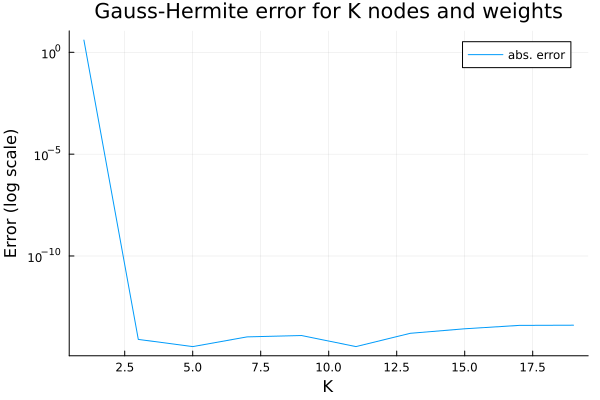

In [11]:
plot(Ks,
errors,
yscale=:log10,
xlabel="K",
ylabel="Error (log scale)",
title="Gauss-Hermite error for K nodes and weights",
label="abs. error",
)

Gauss-Hermite converges much faster than Monte Carlo.

## Part II : The Ayiagari Model

In this exercise, we try to solve the Ayiagari model.

The Ayiagari model features a continuum of households indexed by
$i\in[0,1]$, who take wage rate $\color{red} w$ and interest rate
$\color{red} r$ as given.

Each households $i$ is hit by a random productivity shock
($\color{green}e^i_t$), normally distributed, with variance $\sigma$ and
mean $1$ so that, at the aggregate, the average productivity is $1$.

Each household supplies $\color{green}e^i_t$ units of work, and can
decide to consume $c^i_t$ or save her available income $a^i_{t}$.

Available income $a^i_t$ thus follows the law of motion:

$$a^i_{t+1} = {\color{red}w } {\color{green}e^i_{t+1}} +  (a^i_{t} - c^i_{t}) {\color{red}r}$$

There is no borrowing so that $0<c^i_t\leq a^i_{t}$. The household
choooses consumption optimally in order to maximize:

$$\mathbb{E}_0 \sum_t \beta^t U(c^i_t)$$

with $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta=0.96$,
$\gamma=4.0$.

Aggregate savings are turned into productive capital:

$$K = \int_i a^i_t $$

Note that in equilibrium the distribution of savings is invariant, hence
the absence of a time-subscript for aggregate capital.

Also, the ergodicity property implies that the invariant distribution
across all agents is identical to the distribution of asset levels
reached across time by any single agent $i$ so that we also have:

$$K = \mathbb{E} [ a^i_t ]$$

Capital is rented by competitive firms that all produce with the same
Cobb-Douglas technology. Total production is:

$$Y = K^{\alpha} L^{1-\alpha}$$

with $L=\overline{L}=1$ and $\alpha=0.3$.

Wage rate and interest rate are then determined by marginal conditions:

$${\color{red}r}=\alpha \frac{Y}{K}$$
$${\color{red}w}=(1-\alpha) \frac{Y}{L}$$

From the structure of the whole model, it is clear that capital
$\overline{K}$ determines the whole equilibrium.

> **Note**
>
> Because there is no depreciation, the rental rate determined by the
> marginal conditions, equals the returns on savings when they are
> turned into productive capital.

### Aggregate production

1.  Create a namedtuple (or a structure) `m` to hold all the model
    informations.


In [12]:
m= (;β=0.96, γ=4.0, α=0.3)

(β = 0.96, γ = 4.0, α = 0.3)

2.  Create a function `rates(K,m)::Tuple{Float64,Float64}` that takes
    aggregate capital and return the rental rate of capital and the wage
    rate.


In [13]:
function rates(K,m)
  (;β, α) = m
  Y = K^α
  r = α * Y/K
  w = (1-α) * Y
  return (;r,w)
end

r, w = rates(10,m)

(r = 0.05985786944906638, w = 1.3966836204782156)

3.  Choose an initial level of capital $K_0$ and corresponding rates
    $p_0=(r_0,w_0)$ so that $\beta < \beta r_0 < 1$. Define the
    corresponding varaibles `K_0` and `p_0`.

> **Note**
>
> The second part of this inequality ensures that wealth distribution is
> well defined – agents don’t want to accumulate assets until they have
> unbounded wealth.


In [18]:
K0 = 0.17
p0 = rates(K0,m)

# We assert that β < β*r0 < 1
(m.β < m.β*p0[1]) & (m.β*p0[1] < 1)

true

### Consumption-Savings Problem

We now solve the individual problem given the vector of rates `p`. This
can be done using any solution method (any version of time-iteration for
instance). Here we choose to use the classic value-function iteration
instead.

Given the formulation of the household problem, we can look for a
decision rule for consumption $c(a)$ with $c(a)\in]0,a]$. To implement
value function iteration, we will also define $V(a)$.

> **Note**
>
> Since all agents are identical ex ante, we need to solve only one
> optimization problem. Hence we drop the $i$ subscripts.

In theory, the state-space is $]0,\infty]$ but in practice we
approximate the system on $]0,\overline{A}]$ and adjust $\overline{A}$
until the solution is well defined.

> **Note**
>
> If $\color{green}e^i_t$ has a compact support, theoretical
> considerations show that one can choose such an $\overline{A}$.

4.  Write the Bellman equation

$$
V(a,e) = \max_{c(a) \in ]0,a]} U(c(a)) + βE_{e'}[V(a',e')]
$$
We incorporating the capital law of motion, the Bellman equation rewrite as: 
$$
V(a,e) = \max_{c(a) \in ]0,a]} U(c(a)) + βE_{e'}[V(we'+r(a-c(a)), e')]
$$
with 
$$
e'∼N(1,σ^2)
$$

#### Approximate space

To represent functions ($c()$ and $V()$) using a finite number of
parameters, we discretize the state-space into a finite grid `g`, made
of $N$ linearly spaced points between $\epsilon>0$ and $\overline{A}$
(the role of $\epsilon>0$ is to avoid undefined behaviour for $c=0$).

We use gauss-hermite nodes and weights weights to approximate the shock
$\epsilon$.

5.  Create a namedtuple `dis` to represent the discretized model
    (i.e. the grid and the quadrature).

In [73]:
# Creation of a grid representing the state-space of asset holdings a
N    = 100       # number of grid points
Abar = 100.0      # upper bound of asset grid
a_min = 1e-4     # lower bound (to avoid c=0)

g = range(a_min, Abar, length=N)

# We use gauss-hermite nodes and weights to apporoximate the productivity shock e∼N(1,σ^2)
e_params = (;μ = 1.0, σ = 1.0)
x, w = gausshermite(10, normalize=true)
x_adjust = e_params.μ .+ e_params.σ .* x

# The namedtuple dis represent the discretized model
dis = (
  grid = g,
  nodes = x_adjust,
  weights = w,
)

(grid = 0.0001:1.0101:100.0, nodes = [-3.859462828332312, -2.581823483551927, -1.4843258416389529, -0.46598909439116265, 0.5150642924844988, 1.4849357075155012, 2.465989094391163, 3.484325841638953, 4.581823483551927, 5.859462828332312], weights = [4.31065263071828e-6, 0.0007580709343122154, 0.01911158050077043, 0.13548370298026785, 0.3446423349320186, 0.3446423349320186, 0.13548370298026785, 0.01911158050077043, 0.0007580709343122154, 4.31065263071828e-6])

#### Value Function Iteration

6.  Take an initial guess `vvec` (preferably concave) for the values on
    the grid and define the function
    `value_update(a, c, vvec, m, p, dis)::Float64` which compute the
    expression inside the `max` in the Bellman equation for any state
    `a`, any acceptable consumption level `c` and a continuation value,
    obtained by interpolating the values `vvec` at any point outside the
    grid.


In [ ]:
function utility(c,m)
    (; γ) = m
    return c^(1-γ) / (1-γ)
end

vvec = [utility(a,m) for a in dis.grid]

function value_update(a, c, vvec, m, dis, p)
  (; β) = m
  (; grid, nodes, weights) = dis
  (;w,r) = p

  # Create a linear interpolation object
  itp = linear_interpolation(grid, vvec, extrapolation_bc=Line())

  # Compute present utility
  u = utility(c, m)

  # Compute the expected next-period value function
  EV = zero(u)
  for (e,w) in zip(nodes, weights)
    a_next = w * e + r * (a - c)
    V_next = itp(a_next)
    EV += w * V_next
  end

  return u + β * EV
end

value_update (generic function with 1 method)

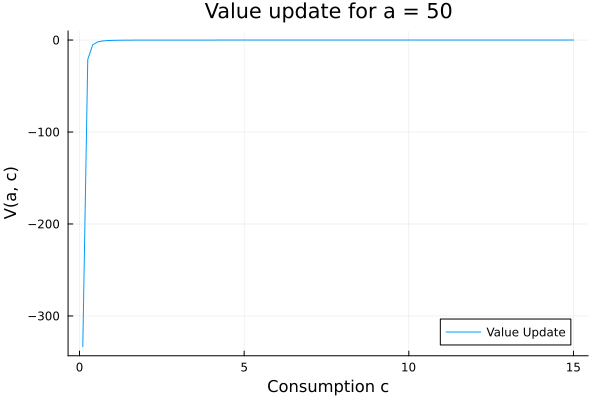

In [97]:
c_vals = range(0.1, 15; length = N)
update_vals = [value_update(70, c, vvec, m, dis, p0) for c in c_vals]
plot(c_vals, update_vals, label="Value Update", xlabel="Consumption c", ylabel="V(a, c)", title="Value update for a = $a")

7.  Use your preferred method for constrained optimization to compute
    the value $c\in]0,a]$ which maximizes the function `value_update`
    for a given `a` of your choice.

> **Note**
>
> This is the crucial step. You can test whether it works for different
> values of `a` and debug what’s going by making a plot.


In [104]:
function optimal_consumption(a, vvec, m, dis, p)
  lower = [first(dis.grid)]
  upper = [last(dis.grid)]

  obj(c) = -value_update(a, c, vvec, m, dis, p)
  result = optimize(obj, lower, upper, [a/2], Fminbox(GradientDescent()))

  c_opt = Optim.minimizer(result)

  return c_opt
end

optimal_consumption (generic function with 1 method)

In [105]:
c_vals = range(0.1, 15; length = N)
update_vals = [value_update(70, c, vvec, m, dis, p0) for c in c_vals]
c_star = optimal_consumption(50, vvec, m, dis, p0)


MethodError: MethodError: no method matching ^(::Vector{Float64}, ::Float64)
The function `^` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  ^(!Matched::ForwardDiff.Dual{Tx}, ::AbstractFloat) where Tx
   @ ForwardDiff ~/.julia/packages/ForwardDiff/UBbGT/src/dual.jl:148
  ^(!Matched::Irrational{:ℯ}, ::Number)
   @ Base mathconstants.jl:139
  ^(!Matched::ForwardDiff.Dual{Tx}, ::Real) where Tx
   @ ForwardDiff ~/.julia/packages/ForwardDiff/UBbGT/src/dual.jl:148
  ...


8.  Write a function
    `bellman_step(vvec, m, p, dis)::Tuple{Vector, Vector}` which takes
    in a vector representing the value function tomorrow and returns a
    new value vector and policy vector resulting from the maximization.


9.  Write a `vfi(m, p, dis)` function, which solves the consumption
    savings problem by value function iteration. It should return the
    vector of values and the consumption vector.


10.  Check that the solution makes sense: plot the solution, the
    boundaries, check the extrapolation behaviour…

#### Policy Function Iteration

11.  Solve the consumption savings problem using policy function
    iteration (i.e. using howard improvement steps). Compare execution
    time with value function iteration.

> **Note**
>
> You might need to define some intermediary functions, like
> `value_step` which updates the value at all grid points, for a given
> vector of policy choices and `policy_eval` which returns the value
> vector obtained by iterating `value_step` many times.


### Computing the Stable Distribution

Now that we have a consumption rule represented by a vector of
consumption values `cvec`, we would like to compute the corresponding
ergodic distribution in order to approximate capital supply $\int_i a_i$

#### With Monte Carlo

12.  Write a function `transition(a, cvec, m, p)` which returns a new
    random asset level, from an initial `a`. The consumption choices are
    defined using `cvec` and can be interpolated as before.


13.  Propose a way to draw $L=1000$ random points from the ergodic
    distribution. Plot the result.

14.  Compute the average of these values. It corresponds to the capital
    supply. What is the standard deviation of this method? (you can
    evaluate the standard deviation by performing the procedure again)


#### With a Markov Chain

15.  Write a function
    `transition(a, c, m, p, dis)::Vector{Tuple{Float64, Float64}}` which
    returns a vector of asset levels with matching probabilities,
    obtained from initial level `a`, with consumption choice `c` for the
    various realizations of the discretized shocks (obtained from the
    quadrature).

16.  Use the `transition` function to define a stochastic matrix `P` of
    size $N\times N$ such that $P_{ij}$ represents the probability of
    reaching grid point $j$ from grid point $i$. Use the trembling hand
    method to deal with asset levels that are out of the approximation
    grid.

> **Tremblilng hand**
>
> When a given asset level $a$ reached with probability $w$ falls
> between two grid points $a_j$ and $a_{j+1}$, we consider that it
> reaches $a_j$ with probability $w\frac{a_{j+1}-a}{a_{j+1}-a_j}$ and
> $a_{j+1}$ with probability $w\frac{a_{a-a_j}{a_{j+1}-a_j}$. This trick
> ensures that the stochastic matrix depends smoothly on the decision
> rule.



17.  Compute the stable distribution $\mu$ of $P$. Compute the capital
    demand.

### Solve the Model

18.  Using everything you have done so far write a function
    `capital_supply(K, m, p, dis)` which computes the rates
    corresponding to `K`, solves the consumption problem, computes the
    ergodic distribution and the corresponding capital supply.


19.  Plot capital supply and capital demand (line $K=K$) for different
    levels of capital. Find the level of capital such that market for
    capital clears.